<a href="https://colab.research.google.com/github/Tyrannozavr/machine_learning/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
!git clone https://github.com/CipiOrhei/TMBuD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4534  100  4534    0     0  78172      0 --:--:-- --:--:-- --:--:-- 78172
Cloning into 'TMBuD'...
remote: Enumerating objects: 2504, done.
remote: Counting objects: 100% (798/798), done.
remote: Compressing objects: 100% (752/752), done.
remote: Total 2504 (delta 53), reused 789 (delta 46), pack-reused 1706
Receiving objects: 100% (2504/2504), 1.86 GiB | 18.17 MiB/s, done.
Resolving deltas: 100% (393/393), done.
Updating files: 100% (1585/1585), done.


In [5]:
%pip install poutyne 
%pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas
import os
import torch
import cv2
from skimage.transform import resize
from google.colab.patches import cv2_imshow
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
from IPython.display import clear_output
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

In [7]:
root = 'TMBuD/'
images_dir = root + 'images/'
lesions_dir = root + 'gt_label/'
dataset_csv = root + 'DATASET SPLIT.csv'

Ну я сразу скажу, что здесь вроде как предусмотрен какой то файл для более простой загрузки датасета, наверное, я сильно не разбирался, установил зависимости, он выдал мне какую то непонятную ошибку и я решил, что мне проще просто использовать эти картинки и не мучить голову свою

In [ ]:
table = pandas.read_csv(dataset_csv)

In [ ]:
table.head()

,Picture Name,Building Name,Coordinates Landmark,Coordinates image,GT salient edges,GT labels,Condition,Quality,Dataset STANDARD,Dataset 3_2,Dataset 3_5_NIGHT,Dataset 3_N,SEMSEG_EVAL_FULL,END
0,1,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75174775294593; 21.22478407583839,Done,Done,NIGHT,GOOD,TRAIN,None,TEST,TEST,TRAIN,'
1,2,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.751577081296176; 21.22472497882864,Done,Done,DAY,GOOD,TRAIN,TRAIN,TRAIN,TRAIN,TRAIN,'
2,3,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75127239101317; 21.22480049167443,Done,Done,DAY,GOOD,TRAIN,TRAIN,TRAIN,TRAIN,TEST,'
3,4,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75127239101317; 21.22480049167443,Done,Done,DAY,GOOD,VAL,TEST,TEST,TEST,TRAIN,'
4,5,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.751259791003264; 21.224710204576198,Done,Done,DAY,GOOD,TEST,None,None,None,TRAIN,'


Так, ну для начала я понял, что смысла в этой таблице для меня особо нет т.к. здесь куча данных, но то, что мне нужно (например количество окон) отсутствует, как и адрес изображения, не знаю какой смысл мне в этой цифре, мол, вот 1 изображение. Была бы польза от полного имени

In [8]:
def get_name(numb):
    if len(str(numb)) == 1:
        return f'0000{numb}.png'
    if len(str(numb)) == 2:
        return f'000{numb}.png'
    if len(str(numb)) == 3:
        return f'00{numb}.png'
    if len(str(numb)) == 4:
        return f'0{numb}.png'
    if len(str(numb)) == 5:
        return f'{numb}.png'

In [70]:
images = []
lesions = []
size = (256, 256)

for i in range(1, 11000):
  img_or = cv2.imread(images_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  img_les = cv2.imread(lesions_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  if img_or is not None and img_les is not None:
    images.append(img_or)
    lesions.append(img_les)

Дело в том, что для решения задачи сегментации мне понадобится метка здания, а для решения задачи регрессии, я думаю, мне понадобятся отмеченные окна, вот их метки я и буду подавать на регрессионную модель, возможно лучше даже обучить 2 разные модели, пока думаю над этим

Нужно оптимизировать этот алгоритм, бо это ужас, к сожалению не удалось сделать красиво одним срезом, похоже так только каждый элемент можно перебрать, ну или я не полностью знаю возможности numpy

Я все таки решил, что надеждней обучить 2 модели, одна будет рисовать фасад здания, другая делать сегментацию окон, дальше эти окна (ну, маску) либо на регрессию, либо даже что то попроще, просто сосчитат пространства зарисованные

Сейчас я попробую при помощи этой функции создать датасет для сегментации окон

In [48]:
image = lesions[0]

In [50]:
image.shape[:2]

(256, 256)

In [72]:
image = lesions[0]

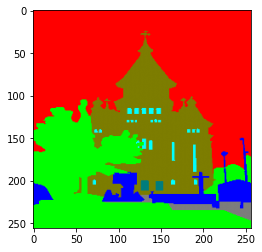

In [64]:
plt.imshow(image)

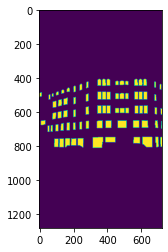

In [76]:
les = np.zeros(image.shape[:2])
for idx_row, row in enumerate(image):
  for idx_col, cell in enumerate(row):
    if any(cell != [0, 255, 255]):
      les[idx_row, idx_col] = 0
    else:
      les[idx_row, idx_col] = 1
plt.imshow(les)

In [79]:
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
from tqdm import tqdm

In [ ]:
df_windows = []
for image in tqdm(lesions):
  les = np.zeros(image.shape[:2])
  for idx_row, row in enumerate(image):
    for idx_col, cell in enumerate(row):
      if any(cell != [0, 255, 255]):
        les[idx_row, idx_col] = 0
      else:
        les[idx_row, idx_col] = 1
  df_windows.append(les)

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(images[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(df_windows[i])
plt.show();

 45%|████▍     | 133/298 [08:09<12:54,  4.70s/it]

попробовать вместо 3 слоев сделать один, как и должно быть в маске

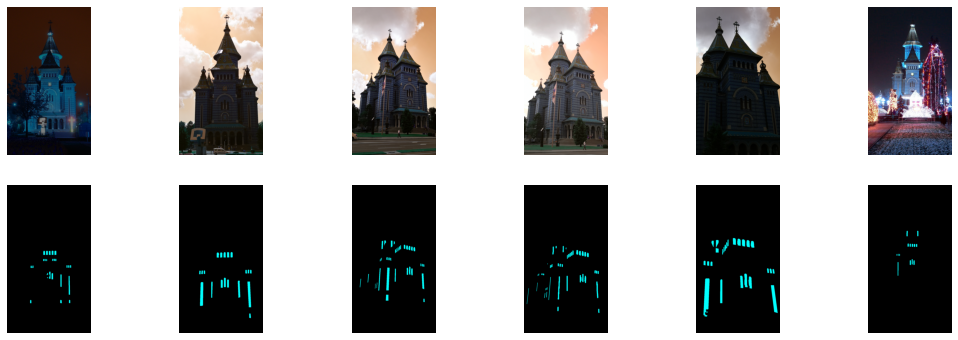

In [13]:
df_windows = []
for image in lesions:
  image = image.copy()
  for idx_row, row in enumerate(image):
    for idx_col, cell in enumerate(row):
      if any(cell != [0, 255, 255]):
            image[idx_row, idx_col] = [0, 0, 0]
  df_windows.append(image)

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(images[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(df_windows[i])
plt.show();

Следующий цикл проходит по сегментированным изображениям и всего лишь удаляет все, кроме окон

In [16]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
    ]
    return albu.Compose(_transform)

from segmentation_models_pytorch.encoders import get_preprocessing_fn

# Initialize the preprocessing function
preprocessing_fn = get_preprocessing_fn(BACKBONE, pretrained='imagenet')

preprocessing = get_preprocessing(preprocessing_fn)

sample = preprocessing(image=image, mask=mask)
image, mask = sample['image'], sample['mask']

NameError: ignored

In [17]:
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) for y in df_windows]

In [ ]:
# !sudo mkdir TMBuD/wind_segm

In [ ]:
# segm = 'TMBuD/wind_segm'
# os.chdir(segm)
# for idx, image in enumerate(df_windows):
#   cv2.imwrite(f'{idx}.png', image)

In [ ]:
len(df_windows)

298

In [22]:
# model = smp.Unet(
#     encoder_name="resnet34",   
#     encoder_weights="imagenet",
#     in_channels=1,             
#     classes=3,                 
# )

In [18]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [200, 275])

In [19]:
X, Y = np.array(X, dtype=np.float64), np.array(Y, np.float64)

In [20]:
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# from google.colab import files

Загрузим данные

In [ ]:
# os.chdir('/content')

In [ ]:
# dir = root+'wind_segm/'

In [ ]:
# for i in os.listdir(dir):
#   files.download(dir+i)

In [ ]:
len(os.listdir(dir))

In [ ]:
len(X), len(Y)

In [ ]:
# reg_model = models.resnet34(pretrained=True)
# in_features = reg_model.fc.in_features
# reg_model.fc = nn.Linear(in_features, 1)

# print(reg_model)

Начнем собирать и тренировать модель

In [ ]:
BACKBONE = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 

seg_model = smp.Unet(
    encoder_name=BACKBONE,
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(BACKBONE, ENCODER_WEIGHTS)

In [ ]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
    ]
    return albu.Compose(_transform)

In [23]:
test_x, test_y= next(iter(data_tr))

In [26]:
test_x = test_x.float()
seg_model = smp.Unet(
    encoder_name='resnet34', 
    encoder_weights='imagenet', 
    classes=1, 
    activation='sigmoid',
)
imgs = seg_model(test_x)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [27]:
imgs = imgs.detach().numpy()

In [ ]:
imgs.shape

In [30]:
imgs.shape

(25, 1, 256, 256)

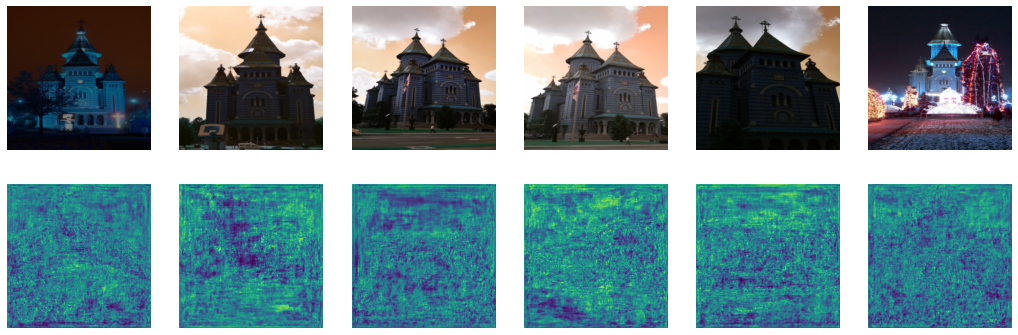

In [44]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(resize(images[i], (256, 256, 3)))

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(imgs[i].squeeze())
    # plt.imshow(resize(imgs[i], (256, 256, 1)))
plt.show();

In [38]:
np.rollaxis(images[k], 0, 3).shape

(720, 3, 1280)

In [ ]:


BACKBONE = 'resnet34'

IMAGE_HEIGHT_ORIG = 1024
IMAGE_WIDTH_ORIG = 1024
IMAGE_CHANNELS_ORIG = 3

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMAGE_CHANNELS = 3

BATCH_SIZE = 8

SAMPLE_SIZE = 15

NUM_EPOCHS = 30

THRESHOLD = 0.7

LRATE = 0.0001

# Check the number of available cpu cores.
# This variable is used to set the num workers in the data loader.
NUM_CORES = os.cpu_count()

NUM_CORES
import segmentation_models_pytorch as smp
# 3x512x512 RGB pre-processed image


# seg_model Output:
# .................

# Mask with values in range 0 to 1


ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 

# create segmentation model with pretrained encoder
seg_model = smp.Unet(
    encoder_name=BACKBONE, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(BACKBONE, ENCODER_WEIGHTS)

print(seg_model)